**Easiest Explanations**: 
- Overall VAE: https://kvfrans.com/variational-autoencoders-explained/
- Reparametrization: https://dilithjay.com/blog/the-reparameterization-trick-clearly-explained

**Code**:
- https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py

In [78]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from torch.nn import functional as F

In [2]:
from keras.datasets import mnist
import numpy as np

2025-02-23 05:56:18.842905: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-23 05:56:18.959403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740290179.051911      56 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740290179.078128      56 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 05:56:19.309714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appro

In [141]:
(x_train, _), (x_test, _) = mnist.load_data()

In [142]:
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

In [143]:
x_train = torch.tensor(x_train).unsqueeze(1) # adding an extra dimension at 1st index, as channel dimension
x_test = torch.tensor(x_test).unsqueeze(1)

In [144]:
train_dl = torch.utils.data.DataLoader(x_train,batch_size=60,shuffle=True)
val_dl = torch.utils.data.DataLoader(x_test,batch_size=60,shuffle=True)

In [145]:
latent_dim = 128

In [180]:
# Defining Autoencoder model
class Autoencoder_conv(nn.Module):
    def __init__(self):
        super(Autoencoder_conv, self).__init__()
        self.encoder = nn.Sequential(
               nn.Conv2d(1,32,3,padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2,2),
               nn.Conv2d(32,16,3,padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2,2),
               nn.Conv2d(16,8,3,padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2,2),
            
           )
        self.decoder = nn.Sequential(
           nn.ConvTranspose2d(8,8,3,stride=2),
           nn.ReLU(),
           nn.ConvTranspose2d(8,16,2,stride=2),
           nn.ReLU(),
           nn.ConvTranspose2d(16,32,2,stride=2),
           nn.ReLU(),
           nn.Conv2d(32,1,3,padding=1),
           nn.Sigmoid(),
       )
        
        self.fc_mu = nn.Linear(8*9, latent_dim)
        self.fc_var = nn.Linear(8*9, latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim, 8*9)
        
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def forward(self, x):
        encoded = self.encoder(x)
        result = torch.flatten(encoded, start_dim=1)
        
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        
        z = self.reparameterize(mu, log_var)
        
        decoded = self.decoder_input(z)
        decoded = decoded.view(-1,8,3,3)
        x_ = self.decoder(decoded)
        return  [x_, x, mu, log_var]

### **Derivation of KL Divergence Between Two Gaussians**  

We want to compute the **KL divergence** between the approximate posterior $ q(z | x) $ and the prior $ p(z) $, both of which are Gaussian distributions:  

$
D_{KL}( q(z | x) || p(z) ) = \int q(z | x) \log \frac{q(z | x)}{p(z)} dz
$

Given:  
- $ q(z | x) = \mathcal{N}(\mu, \sigma^2 I) $ (learned latent distribution)  
- $ p(z) = \mathcal{N}(0, I) $ (standard normal prior)

Let’s **derive** the formula step by step.

---

## **Step 1: Write the Gaussian Probability Density Functions**  

For a **multivariate Gaussian** $ \mathcal{N}(\mu, \Sigma) $, the probability density function is:

$
p(z) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp \left( -\frac{1}{2} (z - \mu)^T \Sigma^{-1} (z - \mu) \right)
$

For our specific case:  
1. The prior **$ p(z) $** is a **standard Gaussian** $ \mathcal{N}(0, I) $, so:

   $
   p(z) = \frac{1}{(2\pi)^{d/2}} \exp \left( -\frac{1}{2} z^T z \right)
   $

2. The approximate posterior **$ q(z | x) $** is a Gaussian $ \mathcal{N}(\mu, \sigma^2 I) $:

   $
   q(z | x) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp \left( -\frac{1}{2} (z - \mu)^T \Sigma^{-1} (z - \mu) \right)
   $

   Since $ \Sigma = \text{diag}(\sigma^2) $, we can write:

   $
   q(z | x) = \frac{1}{(2\pi)^{d/2} \prod_{i} \sigma_i} \exp \left( -\frac{1}{2} \sum_{i} \frac{(z_i - \mu_i)^2}{\sigma_i^2} \right)
   $

---

## **Step 2: Compute the KL Divergence Formula**
$
D_{KL}( q(z | x) || p(z) ) = \int q(z | x) \log \frac{q(z | x)}{p(z)} dz
$

### **Step 2.1: Compute the Log Term**
$
\log \frac{q(z | x)}{p(z)} = \log q(z | x) - \log p(z)
$

Using our Gaussian density functions:

$
\log q(z | x) = -\frac{d}{2} \log (2\pi) - \sum_{i} \log \sigma_i - \frac{1}{2} \sum_{i} \frac{(z_i - \mu_i)^2}{\sigma_i^2}
$

$
\log p(z) = -\frac{d}{2} \log (2\pi) - \frac{1}{2} \sum_{i} z_i^2
$

So the log fraction becomes:

$
\log \frac{q(z | x)}{p(z)} = -\sum_{i} \log \sigma_i - \frac{1}{2} \sum_{i} \frac{(z_i - \mu_i)^2}{\sigma_i^2} + \frac{1}{2} \sum_{i} z_i^2
$

---

### **Step 2.2: Compute the Expectation $ \mathbb{E}_{q(z | x)} [\log q(z | x) - \log p(z)] $**

Since KL divergence integrates over $ q(z | x) $, we take the expectation:

$
D_{KL}( q(z | x) || p(z) ) = \mathbb{E}_{q(z | x)} \left[ \log q(z | x) - \log p(z) \right]
$

For the expectation of individual terms:

1. **Expectation of $ \sum_{i} z_i^2 $ under $ q(z | x) $**  
   Since $ z \sim \mathcal{N}(\mu, \sigma^2) $, we use:

   $
   \mathbb{E}_{q(z | x)} [z_i^2] = \text{Var}[z_i] + (\mathbb{E}[z_i])^2 = \sigma_i^2 + \mu_i^2
   $

2. **Expectation of $ \sum_{i} \frac{(z_i - \mu_i)^2}{\sigma_i^2} $ under $ q(z | x) $**  
   The term $ (z_i - \mu_i)^2 / \sigma_i^2 $ follows a chi-squared distribution with mean **1**, so:

   $
   \mathbb{E}_{q(z | x)} \left[ \sum_{i} \frac{(z_i - \mu_i)^2}{\sigma_i^2} \right] = d
   $

3. **Expectation of $ \sum_{i} \log \sigma_i $ is just the term itself** since it is independent of $ z $.

Putting it all together:

$
D_{KL}( q(z | x) || p(z) ) = \sum_{i} \left( \log 1 - \log \sigma_i - \frac{1}{2} (1 - \sigma_i^2 - \mu_i^2) \right)
$

$
= \frac{1}{2} \sum_{i} \left( \sigma_i^2 + \mu_i^2 - \log \sigma_i^2 - 1 \right)
$

---

## **Final KL Loss Formula**
$
D_{KL}( q(z | x) || p(z) ) = \frac{1}{2} \sum_{i=1}^{d} \left( \sigma_i^2 + \mu_i^2 - \log \sigma_i^2 - 1 \right)
$

---

## **Key Takeaways**
1. **This KL divergence term acts as a regularizer** in VAEs, ensuring that the latent distribution does not drift too far from the prior $ \mathcal{N}(0, I) $.
2. **The formula arises naturally from the expectation over Gaussian distributions**.
3. **Minimizing KL Loss encourages the encoder to output latent representations that are close to a unit Gaussian**, making sampling and generation smooth.

In [186]:
def loss_function(recons, input_, mu, log_var):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """

        kld_weight = 0.00025 #kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input_)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return loss

In [187]:
# Setting random seed for reproducibility
torch.manual_seed(30)
model = Autoencoder_conv()

In [188]:
model = model.to("cuda")

In [189]:
num_epochs = 50
criterion = loss_function
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=0.0001,steps_per_epoch=len(train_dl),epochs=num_epochs)

In [190]:
# Training the autoencoder
for epoch in range(num_epochs):
    model.train()
    trl = 0
    for bat in train_dl:
        train_data = bat.to("cuda")
        # Forward pass
        recons, input_, mu, log_var = model(train_data)
        loss = criterion(recons, input_, mu, log_var)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        sched.step()
        trl += loss.item()
        
    model.eval()
    vl = 0
    with torch.no_grad():
        for bat_val in val_dl:
            val_data = bat_val.to("cuda")
            recons, input_, mu, log_var = model(val_data)
            val_loss = criterion(recons, input_, mu, log_var)
            vl += val_loss.item()

    # Loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {trl/len(train_dl):.4f}, Val_Loss: {vl/len(val_dl):.4f}')

Epoch [1/50], Loss: 0.2266, Val_Loss: 0.2240
Epoch [2/50], Loss: 0.2194, Val_Loss: 0.2133
Epoch [3/50], Loss: 0.1942, Val_Loss: 0.1374
Epoch [4/50], Loss: 0.0964, Val_Loss: 0.0813
Epoch [5/50], Loss: 0.0760, Val_Loss: 0.0734
Epoch [6/50], Loss: 0.0702, Val_Loss: 0.0676
Epoch [7/50], Loss: 0.0646, Val_Loss: 0.0622
Epoch [8/50], Loss: 0.0593, Val_Loss: 0.0569
Epoch [9/50], Loss: 0.0547, Val_Loss: 0.0524
Epoch [10/50], Loss: 0.0510, Val_Loss: 0.0491
Epoch [11/50], Loss: 0.0482, Val_Loss: 0.0466
Epoch [12/50], Loss: 0.0460, Val_Loss: 0.0448
Epoch [13/50], Loss: 0.0442, Val_Loss: 0.0429
Epoch [14/50], Loss: 0.0424, Val_Loss: 0.0411
Epoch [15/50], Loss: 0.0409, Val_Loss: 0.0396
Epoch [16/50], Loss: 0.0394, Val_Loss: 0.0383
Epoch [17/50], Loss: 0.0382, Val_Loss: 0.0371
Epoch [18/50], Loss: 0.0370, Val_Loss: 0.0360
Epoch [19/50], Loss: 0.0360, Val_Loss: 0.0351
Epoch [20/50], Loss: 0.0350, Val_Loss: 0.0341
Epoch [21/50], Loss: 0.0342, Val_Loss: 0.0334
Epoch [22/50], Loss: 0.0334, Val_Loss: 0.03

In [191]:
i = 21

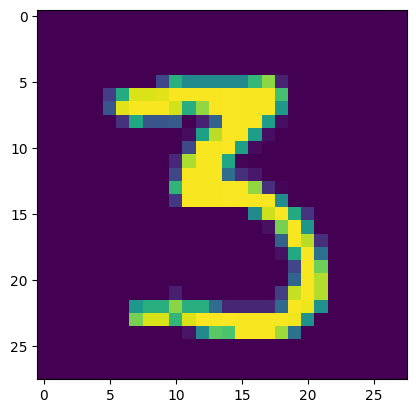

In [176]:
plt.imshow(bat_val[i].reshape(28,28))

In [177]:
output = model(bat_val[i].unsqueeze(0).to("cuda"))[0].detach().cpu()

In [178]:
output.shape

torch.Size([1, 1, 28, 28])

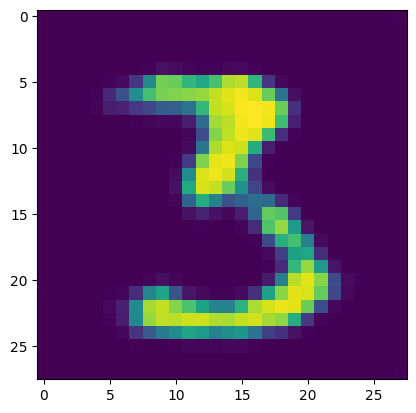

In [179]:
plt.imshow(output[0].reshape(28,28))

How come, 
z = torch.normal(mu, sigma) is not differentiable, 
but,
epsilon = torch.randn_like(sigma)  # Sample from standard normal
 z = mu + sigma * epsilon 
is differentiable?


- Great question! The key difference lies in **how randomness interacts with the computational graph** and whether the function is **deterministic with respect to the parameters**.

---

## **1. Why Is `z = torch.normal(mu, sigma)` Not Differentiable?**
When you use:
```python
z = torch.normal(mu, sigma)
```
you are directly sampling from a normal distribution. This operation **does not have a well-defined gradient** because it introduces **stochasticity into the computation graph itself**.

### **Breaking Down the Issue:**
- `torch.normal(mu, sigma)` generates new random numbers in each forward pass.
- Since sampling from a probability distribution is **non-differentiable**, there is **no explicit mathematical function** linking `z` to `mu` and `sigma` in a way that allows derivatives.
- As a result, PyTorch **does not track gradients** for `z`, and calling `.backward()` on a loss computed using `z` leads to an error.

This is why `torch.normal(mu, sigma)` **breaks backpropagation**.

---

## **2. Why Is `z = mu + sigma * epsilon` Differentiable?**
When you use:
```python
epsilon = torch.randn_like(sigma)  # Sample from N(0,1) (fixed distribution)
z = mu + sigma * epsilon  # Reparameterization trick
```
you **separate** the randomness (sampling `epsilon`) from the learnable parameters (`mu` and `sigma`).

### **Breaking Down Why It Works:**
- **`epsilon` is sampled independently** from \( \mathcal{N}(0,1) \), which means it does not depend on `mu` or `sigma`. Since it's just a tensor of random numbers, it is treated as a constant during differentiation.
- The transformation:
  \[
  z = \mu + \sigma \cdot \epsilon
  \]
  is a **fully differentiable function** with respect to `mu` and `sigma`:
  - \( \frac{\partial z}{\partial \mu} = 1 \) (gradients can flow directly)
  - \( \frac{\partial z}{\partial \sigma} = \epsilon \) (gradients propagate correctly)
- Since every operation in `mu + sigma * epsilon` is differentiable, **PyTorch can compute gradients** and backpropagate without issues.

---

## **3. Key Intuition**
- **`torch.normal(mu, sigma)` is a "hard" sampling step**—there's no deterministic function linking `z` to `mu` and `sigma`, so gradients cannot be computed.
- **`z = mu + sigma * epsilon` transforms a fixed random variable `epsilon`** into `z` in a differentiable way.

This is why the **reparameterization trick** is necessary for VAEs to work with backpropagation.

---

(array([   9.,   87.,  421., 1505., 2746., 2952., 1658.,  508.,  104.,
          10.]),
 array([4.19651318, 4.3547492 , 4.51298571, 4.67122173, 4.82945824,
        4.98769426, 5.14593029, 5.30416679, 5.46240282, 5.62063932,
        5.77887535]),
 <BarContainer object of 10 artists>)

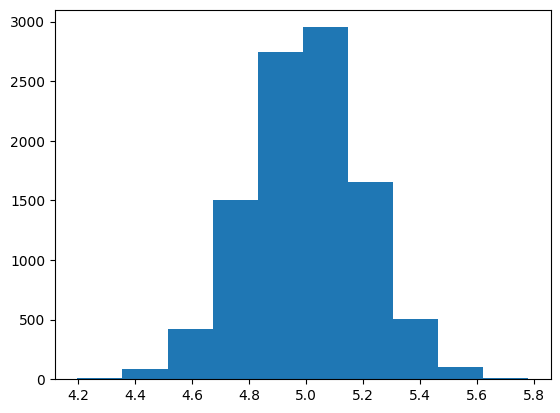

In [205]:
temp = []

for i in range(10000):
    temp.append(torch.normal(torch.tensor(5.0),torch.tensor(0.2)))
plt.hist(temp)

(array([5.000e+00, 6.700e+01, 5.130e+02, 1.724e+03, 3.198e+03, 2.892e+03,
        1.256e+03, 3.130e+02, 2.900e+01, 3.000e+00]),
 array([-4.10888386, -3.25992298, -2.4109621 , -1.56200123, -0.71304035,
         0.13592052,  0.9848814 ,  1.83384228,  2.68280315,  3.53176403,
         4.38072491]),
 <BarContainer object of 10 artists>)

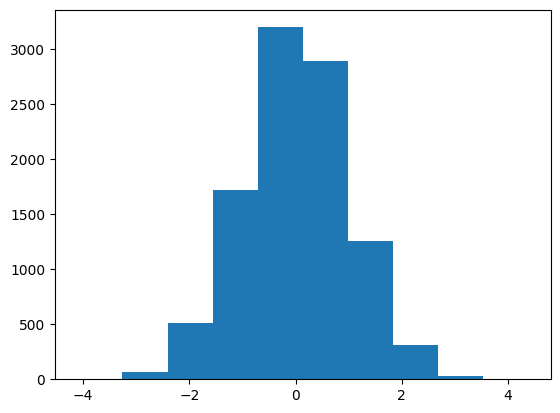

In [206]:
temp = []

for i in range(10000):
    temp.append(torch.normal(torch.tensor(0.0),torch.tensor(1.0)))
plt.hist(temp)